<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-Phase2/blob/master/GAN_Car_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
!unzip -q '/content/gdrive/My Drive/car_dataset.zip' -d '/content/'

In [3]:
ls /content/car_dataset/cars

100.jpg  157.jpg  212.jpg  269.jpg  324.jpg  380.jpg  436.jpg  492.jpg  548.jpg
101.jpg  158.jpg  213.jpg  26.jpg   325.jpg  381.jpg  437.jpg  493.jpg  549.jpg
102.jpg  159.jpg  214.jpg  270.jpg  326.jpg  382.jpg  438.jpg  494.jpg  54.jpg
103.jpg  15.jpg   215.jpg  271.jpg  327.jpg  383.jpg  439.jpg  495.jpg  550.jpg
104.jpg  160.jpg  216.jpg  272.jpg  328.jpg  384.jpg  43.jpg   496.jpg  551.jpg
105.jpg  161.jpg  217.jpg  273.jpg  329.jpg  385.jpg  440.jpg  497.jpg  552.jpg
106.jpg  162.jpg  218.jpg  274.jpg  32.jpg   386.jpg  441.jpg  498.jpg  553.jpg
107.jpg  163.jpg  219.jpg  275.jpg  330.jpg  387.jpg  442.jpg  499.jpg  554.jpg
108.jpg  164.jpg  21.jpg   276.jpg  331.jpg  388.jpg  443.jpg  49.jpg   555.jpg
109.jpg  165.jpg  220.jpg  277.jpg  332.jpg  389.jpg  444.jpg  4.jpg    556.jpg
10.jpg   166.jpg  221.jpg  278.jpg  333.jpg  38.jpg   445.jpg  500.jpg  557.jpg
110.jpg  167.jpg  222.jpg  279.jpg  334.jpg  390.jpg  446.jpg  501.jpg  55.jpg
111.jpg  168.jpg  223.jpg  27.jpg   335.jp

In [4]:

import os
import random
import torch
import time

import torch.nn as nn
import torch.nn.utils as tutils
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
%matplotlib inline
from matplotlib import rc
import seaborn as sns
from IPython import display

from pathlib import Path
from torchsummary import summary

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 66.6MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [6]:
dataroot = '/content/car_dataset'
batch_size = 256
image_size = 128
nc=3
nz=64
ngf=64
ndf=64
num_epochs=2000
lr=0.0001
beta1=0.5

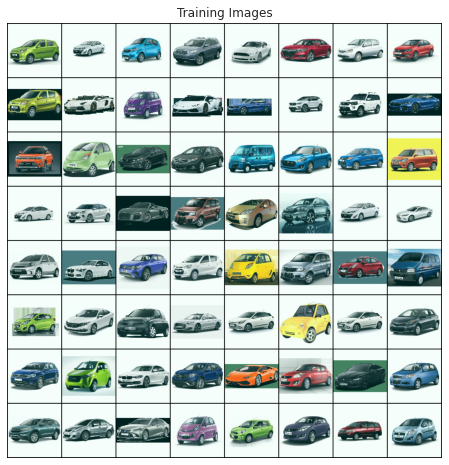

In [7]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=T.Compose([
                                                T.Resize((image_size, image_size)),
                                                T.ToTensor(),
                                                T.Normalize(mean=[0.570838093757629, 0.479552984237671, 0.491760671138763], std=[0.279659748077393, 0.309973508119583, 0.311098515987396]),
                                                ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
class Generator(nn.Module):
    """
    Creates the Generator

    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nz: int = 64, ngf: int = 64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [10]:
class Discriminator(nn.Module):
    """
    Creates the Discriminator

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator

    This uses the special Spectral Normalization ref: https://arxiv.org/abs/1802.05957
    """
    def __init__(self, nc: int = 3, ndf: int = 64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            torch.nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
netG = Generator(nz, ngf).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(6

In [12]:
netD = Discriminator(nc, ndf).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [13]:
summary(netG, input_size=(64, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         524,288
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]          65,536
      BatchNorm2d-14           [-1, 64,

In [14]:
summary(netD, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
         LeakyReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         262,144
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 4, 4]       1,048,576
        LeakyReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11              [-1, 1, 1, 1]           4,096
          Sigmoid-12              [-1, 1, 1, 1]               0
Total params: 1,973,248
Trainable params: 1,973,248
Non-trainable params: 0
---------------------------

In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print(f"=> Starting Training Loop for {num_epochs} epochs\n")

print_freq = 20

curr_time = time.time()
# For each epoch
for epoch in range(num_epochs):

    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    epoch_end = time.time()

    # Output training stats every `print_freq` or if its end epoch
    if epoch % print_freq == 0 or epoch == num_epochs -1:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        generator_log = Path('generator_log')
        generator_log.mkdir(parents=True, exist_ok=True) 

        plt.imsave(generator_log / f'g_log_{epoch:04}.jpg', np.transpose(img_list[-1].numpy(), (1, 2, 0)))

        checkpoint_dir = Path('checkpoints')
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        torch.save(netG.state_dict(), checkpoint_dir / f'netG_chkpt_{epoch:04}.pth')

        print('=> Epoch [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tTime: %.5fs'
                  % (epoch, num_epochs-1, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, time.time()-curr_time))
        # start the timer again
        curr_time = time.time()

=> Starting Training Loop for 2000 epochs

=> Epoch [0/1999]	Loss_D: 0.9989	Loss_G: 0.6043	D(x): 0.7961	D(G(z)): 0.5366 / 0.5465	Time: 2.49054s
=> Epoch [20/1999]	Loss_D: 0.8997	Loss_G: 0.6076	D(x): 0.9931	D(G(z)): 0.5904 / 0.5447	Time: 44.15543s
=> Epoch [40/1999]	Loss_D: 0.8852	Loss_G: 0.6623	D(x): 0.9343	D(G(z)): 0.5571 / 0.5160	Time: 45.34951s
=> Epoch [60/1999]	Loss_D: 1.0159	Loss_G: 0.5581	D(x): 0.8602	D(G(z)): 0.5776 / 0.5724	Time: 46.51243s
=> Epoch [80/1999]	Loss_D: 0.9045	Loss_G: 0.6374	D(x): 0.8950	D(G(z)): 0.5467 / 0.5288	Time: 46.89804s
=> Epoch [100/1999]	Loss_D: 0.8619	Loss_G: 0.6298	D(x): 0.7931	D(G(z)): 0.4559 / 0.5331	Time: 47.21348s
=> Epoch [120/1999]	Loss_D: 1.0503	Loss_G: 0.8841	D(x): 0.9816	D(G(z)): 0.6432 / 0.4139	Time: 47.08819s
=> Epoch [140/1999]	Loss_D: 1.2419	Loss_G: 0.5353	D(x): 0.9829	D(G(z)): 0.7055 / 0.5862	Time: 47.20923s
=> Epoch [160/1999]	Loss_D: 0.8387	Loss_G: 0.8642	D(x): 0.8931	D(G(z)): 0.5132 / 0.4219	Time: 47.33422s
=> Epoch [180/1999]	Loss_D: 

In [17]:
! zip -rq car_gan_g_log.zip generator_log/
! zip -rq car_gan_custom_checkpoints.zip checkpoints/

In [19]:
state = {
    'epoch': epoch,
    'netD': netD.state_dict(),
    'netG': netG.state_dict(),
    'optimizerD': optimizerD.state_dict(),
    'optimizerG': optimizerG.state_dict(),
    'img_list': img_list
}
torch.save(state, '/content/car_GAN_checkpoint.pth')

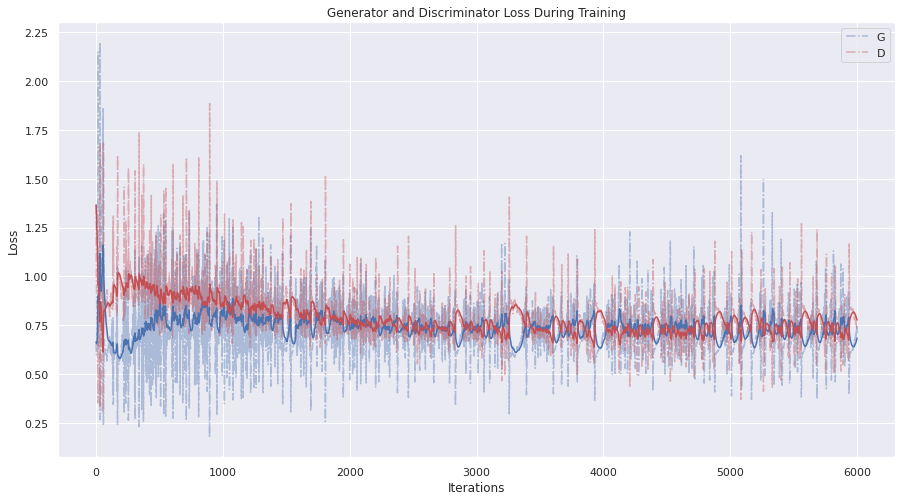

In [20]:
def smooth_curv(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

plt.figure(figsize=(15, 8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, 'b-.',label="G", alpha=0.4)
plt.plot(D_losses, 'r-.', label="D", alpha=0.4)
plt.plot(smooth_curv(G_losses, 0.95), 'b')
plt.plot(smooth_curv(D_losses, 0.95), 'r')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored

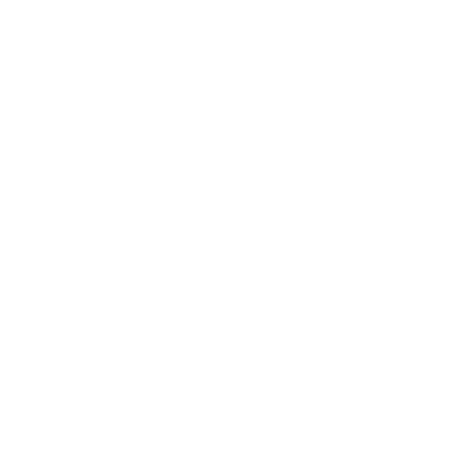

In [22]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

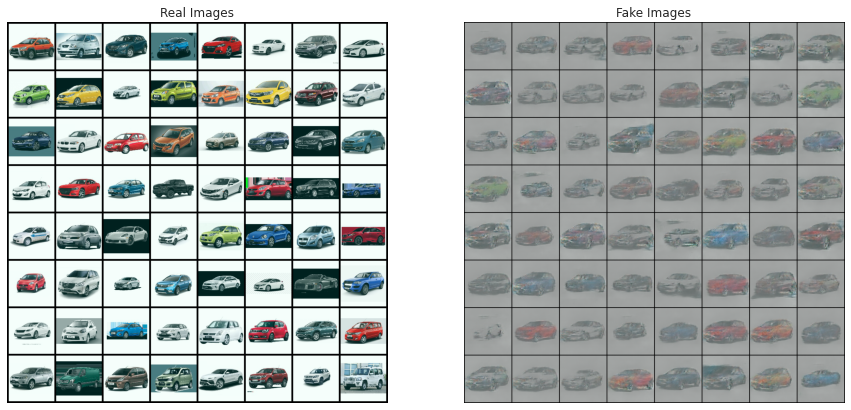

In [23]:

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-10],(1, 2, 0)))
plt.show()

In [24]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

In [25]:
netG.load_state_dict(torch.load('checkpoints/netG_chkpt_1520.pth'))

<All keys matched successfully>

In [26]:

with torch.no_grad():
    fake = netG(torch.randn(1, 64, 1, 1).to(device)).detach().cpu()
fakei = fake[0]
norm_tensor(fakei)

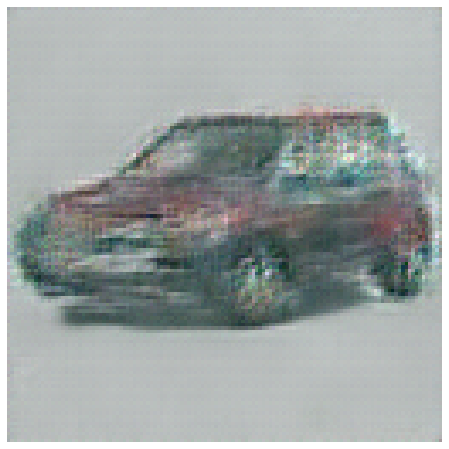

In [27]:
plt.figure(figsize=(8, 8))
plt.imshow(fakei.permute(1, 2, 0))
plt.axis('off')
plt.grid('off')

In [28]:
torch.save(netG, '/content/generator.pt')

In [29]:

traced_model = torch.jit.trace(netG.to('cpu'), torch.randn(1, 64, 1, 1))

In [30]:
traced_model.save('/content/generator.traced.pt')